# Transformer model for language translation

In this notebook, I am implementing from scratch the Transformer, a network architecture that was proposed in the paper "Attention Is All You Need" (Vaswani et al., Attention is all you need, Advances in neural information processing systems, 2017) and I am applying it to translate sentences from Portuguese to English. The Transformer is based solely on attention mechanisms, without any use of LSTMs or RNNs.

The dataset, the hyperparameters' values and the examples used for the evaluation were taken from https://www.tensorflow.org/tutorials/text/transformer for comparison reasons. The figures are taken from the above referenced paper.



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import time
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow_datasets as tfds
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

print(tf.__version__)
print("Eager execution: {}".format(tf.executing_eagerly()))

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

1.15.0
Eager execution: True


In [2]:
import warnings

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


## Use of Portuguese-English translation dataset 

### The following cells which load and process the dataset were taken from https://www.tensorflow.org/tutorials/text/transformer

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [4]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [5]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [6]:
train_preprocessed = (
    train_examples
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

val_preprocessed = (
    val_examples
    .map(tf_encode)
    .filter(filter_max_length))  

In [7]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_preprocessed
               .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [8]:
print(tokenizer_pt.vocab_size)
print(tokenizer_en.vocab_size)

8214
8087


In [9]:
# for i in range(tokenizer_en.vocab_size):
#     print(i,tokenizer_en.decode([i]))

In [10]:
# for i in range(tokenizer_pt.vocab_size):
#     print(i,tokenizer_pt.decode([i]))

## Training dataset

In [11]:
# make the training dataset in proper format for TensorFlow 1.15
X_train = []
Y_train = []
for (batch, (inp, tar)) in enumerate(train_dataset):
    X_train.append(inp.numpy())
    Y_train.append(tar.numpy())

## Create input placeholders

In [12]:
def build_inputs():
    
    encoder_input = tf.placeholder(tf.int32,[None,None],name='encoder_input')
    decoder_input = tf.placeholder(tf.int32,[None,None],name='decoder_input')
    target = tf.placeholder(tf.int32,[None,None],name='target')
    
    return encoder_input, decoder_input, target

## Positional encoding

<img src="images/positional_encoding.png" style="width:100;height:100px;"> <br>

In [13]:
def positional_encoding(position, d_model):
        
    pos = np.arange(0,position)
    pos = pos.reshape(-1,1)
    
    div_term = 10000**(np.arange(0, d_model, 2)/d_model)
        
    pe = np.zeros((position, d_model))
    pe[:,0::2] = np.sin(pos/div_term)
    pe[:,1::2] = np.cos(pos/div_term)
        
    positional_enc = tf.convert_to_tensor(pe, dtype=tf.float32) # (position, d_model)
    positional_enc = positional_enc[np.newaxis, :,:] # (1, position, d_model)
        
    return positional_enc

## Scaled dot product attention

<img src="images/scaled_dot_product_attention.png" style="width:300;height:300px;"> <br>
<img src="images/attention.png" style="width:100;height:100px;"> <br>

We want to have an encoding for each word (token) of each sentence in the encoder or the decoder. In the calculations, we don't use the token directly, but the embedded representation of the word (token) projected to a subspace. 

The scaled dot product attention gives the encoding of each word (query) as the weighted sum of the similarity of the query word to all the other words (keys) in the sentence multiplied with the words of the sentence (values). 

For the Multi-Head Attention block in the encoder or the Masked Multi-Head Attention block in the Decoder, we are in the case of **self-attention**. In that case, we want to see how each word (query) of a sentence is related to all the other words (including itself) of the same sentence. 

The weights i.e. softmax(QK^T/sqrt(dk)),  are the similarity of the word (query) with each the words of the same sentence (keys). The weights are then multiplied with each word of the sentence (value) to get the encoding of the query. 

For the Multi-Head Attention block in the decoder, we are in the case of **attention**. In that case, we want to see how each word (query) of the decoder sentence is related to the words of the encoder sentence. The weights are the similarity of the word (query) of the decoder with each word of the encoder sentence (keys). The weights are then multiplied with each word of the encoder sentence (value) to get the encoding of the query (decoder word). 

If for some words (values) the mask is equal to 1 (i.e. the words have been padded or correspond to future words), we do not want to take into account these words in the encoding of the query. For this reason the weights, which will be multiplied with the words that have a mask of 1, are set equal to 0.

In [14]:
def scaled_dot_product_attention(queries, keys, values, mask):
 
    # queries, keys and values are the projected embeddings that have been split into a specific subspace
    # The number of subspaces is equal to the number of attention heads
    
    # queries: (batch_size, Tq, dq)
    # keys: (batch_size, Tk, dk)
    # values: (batch_size, Tv, dv)
    # where dq = dk = dv = d_model/num_heads and Tk = Tv (for self-attention Tq = Tk = Tv)
    
    
    # Q*K^T/sqrt(dk)
    product = tf.matmul(queries, tf.transpose(keys, [0, 2, 1]))  # (batch_size, Tq, Tk)
    d_k = tf.cast(tf.shape(keys)[-1], tf.float32)
    logits = product / tf.math.sqrt(d_k)

    # mask has size either:
    # 1. (batch_size, 1, Tv) used for encoder self-attention or encoder-decoder attention (2nd attention block of the 
    # decoder)
    # or
    # 2. (batch_size, Tq, Tv) used for decoder self-attention (1st attention block of the decoder)
    if mask is not None:
        logits += (mask * -1e9) # making the locations where the token is 1, a very negative number so the weight 
                                # at this location becomes 0
    
    # softmax(Q*K^T/sqrt(dk))
    # weights are the similarity of the query with each the words of keys
    weights = tf.nn.softmax(logits, axis=-1)  # (batch_size, Tq, Tk)
    # If the input sentence has N padding tokens at the end, then the matrix weights (think of it as shape (Tq,Tk))
    # has the last N columns being 0.
    # That means that at each column of matrix values (think of it as shape (Tv, dv)), the last N numbers 
    # of the column are not used since they are multiplied with 0. In other words the last N rows of matrix values 
    # are not used. The padding mask disables the last N rows of matrix values.
    
    # softmax(Q*K^T/sqrt(dk))*V
    output = tf.matmul(weights, values)  # (batch_size, Tq, dv)
    
    return output

Let's assume we want to find the encoding of the first word of the following sentence which is an input of the encoder.

If the input sentence consists of the following 40 tokens

[[8214 149    6 1748   50    5   34    3 5033  887  238 8215    0    0 0    0    0    0    0    0    0    0    0    0    0    0    0    0 0    0    0    0    0    0    0    0    0    0    0    0]]
     
then the encoder padding mask is the a tensor of shape (1,1,40) and has values equal to 1 for the N padding tokens

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]

Since the input sentence has N padding tokens at the end, then the matrix weights has the last N columns being 0. The next tensor shows the weights of the query with each of the keys (relation between the first word with all other words in the sentence). Since the last N tokens are the padding token, we do not take them into account by setting equal to 0 the corresponding weights that they will be multiplied with the values. 
   
The weights for the 1st query is a tensor of shape (1,1,40) with the last N weights being 0

[[[0.04349909 0.06763001 0.09824815 0.04452311 0.06439371  0.10503896 
   0.04398107 0.06941279 0.09019028 0.07023811 0.07473257 0.22811212
   0         0         0         0         0         0
   0         0         0         0         0         0
   0         0         0         0         0         0
   0         0         0         0         0         0
   0         0         0 0]]]
   
   
and are multiplied with the values which has shape (1,40,d_model/num_heads) to get the encoding of the query (1st word) which has size (1,1,d_model/num_heads).

## Multi-Head Attention

<img src="images/mha.png" style="width:300;height:300px;"> <br>

In [15]:
def multi_head_attention(values, keys, queries, mask, d_model, num_heads, scope):
    
    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
    
        # queries, keys and values are the embeddings of the input words (they haven't been projected yet, just embeddings)
        # queries: (batch_size, Tq, d_model)
        # keys: (batch_size, Tk, d_model)
        # values: (batch_size, Tv, d_model)
        
        # The input embeddings (i.e. queries, keys and values) are projected to a representation space 
        # by applying a huge linear transformation
        queries_lin = tf.contrib.layers.fully_connected(queries, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform()) 
        # (batch_size, Tq, d_model)
        keys_lin = tf.contrib.layers.fully_connected(keys, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tk, d_model)
        values_lin = tf.contrib.layers.fully_connected(values, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tv, d_model)
            
        # We split the projected embeddings into subspaces.
        # The number of subspaces is equal to the number of attention heads
        queries_split = tf.split(queries_lin, num_heads, axis=2) 
        keys_split = tf.split(keys_lin, num_heads, axis=2) 
        values_split = tf.split(values_lin, num_heads, axis=2) 
        # lists of num_heads elements with each of them having size (batch_size, T, d_model/num_heads) 
        # where T is Tq or Tk or Tv
        
        attention = []
        # We get the encoding of each word (query) at each representation subspace. It is saved in attention_i.
        for head_i in range(num_heads):
            attention_i = scaled_dot_product_attention(queries_split[head_i], keys_split[head_i], 
                                                       values_split[head_i], mask)
            # (batch_size, Tq, d_model/num_heads)
            attention.append(attention_i)
        
        concat_attention = tf.concat(attention, axis = 2) # (batch_size, Tq, d_model)
        
        output = tf.contrib.layers.fully_connected(concat_attention, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform())
        # (batch_size, Tq, d_model)

    return output

## Position wise feed forward network

<img src="images/pwffn.png" style="width:50;height:50px;"> <br>

In [16]:
def point_wise_feed_forward_network(input_, d_model, d_ff, scope):

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        x1 = tf.contrib.layers.fully_connected(input_, d_ff, activation_fn = tf.nn.relu,
                            weights_initializer = tf.keras.initializers.glorot_uniform())  
        # (batch_size, T, d_ff)
        ffn = tf.contrib.layers.fully_connected(x1, d_model, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform()) 
        # (batch_size, T, d_model)
            
    return ffn

## Encoder
<img src="images/encoder_layer.png" style="width:400;height:400px;"> <br>

In [17]:
def encoder_layer(x, mask, d_model, d_ff, num_heads, rate, scope):

    # x is the embedding of the input tokens and has size (batch_size, T_x, d_model)
    # mask is the mask used in the attention block of the encoder (encoder self-attention)
    # to mask the padding tokens of the encoder input and has size (batch_size, 1, T_x)
    
    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        # encoder self-attention
        attention_output = multi_head_attention(x, x, x, mask, d_model, num_heads, 'mha') 
        attention_output = tf.nn.dropout(attention_output, rate = rate)
        # residual connection
        output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attention_output) 
    
        ffn_output = point_wise_feed_forward_network(output_1, d_model, d_ff, 'pwffn')
        ffn_output = tf.nn.dropout(ffn_output, rate = rate)
        # residual connection
        output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output_1 + ffn_output) 
    
    return output_2

In [18]:
def encoder(x, mask, num_layers, d_model, num_heads, d_ff, input_vocab_size, maximum_position_input, rate, scope):

    # x is the embedding of the input tokens and has size (batch_size, T_x, d_model)
    # mask is the mask used in the attention block of the encoder (encoder self-attention)
    # to mask the padding tokens of the encoder input and has size (batch_size, 1, T_x)
    
    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        
        T_x = tf.shape(x)[1]
        pos_encoding = positional_encoding(maximum_position_input, d_model) # (1, maximum_position_input, d_model)
        # maximum_position_input is equal to input_vocab_size
        
        # get the embeddings of the input tokens x
        x = tf.keras.layers.Embedding(input_vocab_size, d_model)(x) # (batch_size, T_x, d_model)
        x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        # add the positional encoding
        x += pos_encoding[:, :T_x, :] # pos_encoding[:, :T_x, :] has shape (1, T_x, d_model)
        # x has shape (batch_size, T_x, d_model)
        x = tf.nn.dropout(x, rate = rate)
    
        for i in range(num_layers):
            x = encoder_layer(x, mask, d_model, d_ff, num_heads, rate, 'Encoder_layer_'+str(i+1))
    
    return x  # (batch_size, T_x, d_model)

## Decoder


<img src="images/decoder_layer.png" style="width:500;height:500px;"> <br>

In [19]:
def decoder_layer(y, encoder_output, mask_1, mask_2, d_model, d_ff, num_heads, rate, scope):

    # y is the embedding of the input tokens and has size (batch_size, T_y, d_model)
    
    # mask_1 is the mask used in the 1st attention block of the decoder (decoder self-attention). 
    # It is a combination of the mask of the padding tokens of the decoder input 
    # and of the mask that prevents positions from attending to subsequent positions of the decoder input. 
    # It has size (batch_size, T_y, T_y)
    
    # mask_2 is used in the 2nd attention block of the decoder (encoder-decoder attention) 
    # to mask the padding tokens of the encoder outputs (input in the 2nd attention block of the decoder) 
    # and has size (batch_size, 1, T_x)
    
    
    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
        # decoder self-attention
        attention_output_1 = multi_head_attention(y, y, y, mask_1, 
                                                                    d_model, num_heads, 'mha_1') 
        attention_output_1 = tf.nn.dropout(attention_output_1, rate = rate)
        # residual connection
        output_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(y + attention_output_1)

        # encoder-decoder attention
        attention_output_2 = multi_head_attention(encoder_output, encoder_output, output_1, 
                                                                    mask_2, d_model, num_heads, 'mha_2')
        attention_output_2 = tf.nn.dropout(attention_output_2, rate = rate)
        # residual connection
        output_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_output_2 + output_1) 
    
        ffn_output = point_wise_feed_forward_network(output_2, d_model, d_ff, 'pwffn')
        ffn_output = tf.nn.dropout(ffn_output, rate = rate)
        # residual connection
        output_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(output_2 + ffn_output)
    
    return output_3

In [20]:
def decoder(y, encoder_output, mask_1, mask_2, num_layers, d_model, num_heads, d_ff, 
                        target_vocab_size, maximum_position_target, rate, scope):
    
    # y is the sequence of words (output tokens) (batch_size, T_y)
    
    # mask_1 is the mask used in the 1st attention block of the decoder (decoder self-attention). 
    # It is a combination of the mask of the padding tokens of the decoder input 
    # and of the mask that prevents positions from attending to subsequent positions of the decoder input. 
    # It has size (batch_size, T_y, T_y)
    
    # mask_2 is used in the 2nd attention block of the decoder (encoder-decoder attention) 
    # to mask the padding tokens of the encoder outputs (input in the 2nd attention block of the decoder) 
    # and has size (batch_size, 1, T_x)

    with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):   
        
        T_y = tf.shape(y)[1] 
        attention_weights = {}    
        pos_encoding = positional_encoding(maximum_position_target, d_model) # (1, maximum_position_target, d_model)
        # maximum_position_target is equal to target_vocab_size
    
        # get the embeddings of the input tokens y
        y = tf.keras.layers.Embedding(target_vocab_size, d_model)(y)  # (batch_size, T_y, d_model)
        y *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        y += pos_encoding[:, :T_y, :] # pos_encoding[:, :T_y, :] has shape (1, T_y, d_model)
        # y has shape (batch_size, T_y, d_model)
        y = tf.nn.dropout(y, rate = rate)
        
        for i in range(num_layers):
            y = decoder_layer(y, encoder_output, mask_1, mask_2, d_model, 
                                              d_ff, num_heads, rate, 'Decoder_layer_'+str(i+1))
    
    return y # (batch_size, T_y, d_model)

## Masks

In [21]:
def padding_mask_function(input_):
    
    # It masks all the padding tokens of the sequence and thus the model does not treat padding as input.
    # The tokens which are masked to 1 will not be used.
    
    # input_ has size # (batch_size, T)
    padding_mask = tf.cast(tf.math.equal(input_, 0), tf.float32) # (batch_size, T)
  
    # add extra dimension to add the padding to the scaled dot product attention logits
    # which have size (batch_size, Tq, Tk)
    return padding_mask[:, tf.newaxis, :]  # (batch_size, 1, T)

If the input sentence consists of the following 40 tokens

[[8214 149    6 1748   50    5   34    3 5033  887  238 8215    0    0 0    0    0    0    0    0    0    0    0    0    0    0    0    0 0    0    0    0    0    0    0    0    0    0    0    0]]
     
then the padding mask is the a tensor of shape (1,1,40) and has values equal to 1 for the N padding tokens,
so that the weights for these locations will become 0 and these words will not be used

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]]

In [22]:
def future_word_mask_function(batch_size, seq_len):
    
    # The future word mask masks the future tokens of the sequence, preventing positions from attending 
    # to subsequent positions of the decoder input. 
    # The tokens which are masked to 1 will not be used.
    # This means that in order to predict the second word, only the first word will be used. To predict the third word,
    # only the first and second will be used.
        
    # seq_len is the length of the target sequence of words and is equal to T_y
    diag_vals = tf.ones((seq_len, seq_len))  # (T_y, T_y)
    tril = 1 - tf.linalg.LinearOperatorLowerTriangular(diag_vals).to_dense() # (T_y, T_y)
    # Return a dense (batch) matrix representing this operator 
    future_word_mask = tf.tile(tril[tf.newaxis, :, :], [batch_size, 1, 1]) # (batch_size, T_y, T_y)

    return future_word_mask  

For batch_size = 2 and T_y = 5 

diag_vals is a tensor of shape (5,5)

[[1 1 1 1 1]

 [1 1 1 1 1]
 
 [1 1 1 1 1]
 
 [1 1 1 1 1]
 
 [1 1 1 1 1]]
 
tril is a tensor of shape (5,5) with values of 1 for the locations of the future words,
so that the weights for the future locations will become 0

[[0 1 1 1 1]

 [0 0 1 1 1]
 
 [0 0 0 1 1]
 
 [0 0 0 0 1]
 
 [0 0 0 0 0]]
 
 Thus, the future_word_mask is a tensor of size (2,5,5)
 
 [[[0 1 1 1 1]
 
  [0 0 1 1 1]
 
 [0 0 0 1 1]
 
 [0 0 0 0 1]
 
 [0 0 0 0 0]]

 [[0 1 1 1 1]
 
 [0 0 1 1 1]
 
 [0 0 0 1 1]
 
 [0 0 0 0 1]
 
 [0 0 0 0 0]]]

In [23]:
def create_masks(encoder_input, decoder_input):
    
    # encoder_input (batch_size, T_x)
    # decoder_input (batch_size, T_y)
    
    # encoder_mask is used in the attention block of the encoder (encoder self-attention)
    # to mask the padding tokens of the encoder input
    encoder_mask = padding_mask_function(encoder_input) # (batch_size, 1, T_x)
    
    # decoder_mask_1 is used in the 1st attention block of the decoder (decoder self-attention) 
    # to mask the padding tokens of the decoder input 
    # and prevent positions from attending to subsequent positions of the decoder input 
    
    # masks the future tokens of the sequence
    future_word_mask = future_word_mask_function(tf.shape(decoder_input)[0], tf.shape(decoder_input)[1]) # (batch_size, T_y, T_y)
    # masks the padding tokens of the decoder input
    decoder_input_padding_mask = padding_mask_function(decoder_input) # (batch_size, 1, T_y)
    # combination of the future_word_mask and the decoder_input_padding_mask masks
    decoder_mask_1 = tf.maximum(decoder_input_padding_mask, future_word_mask) # (batch_size, T_y, T_y)
  
    # decoder_mask_2 is used in the 2nd attention block of the decoder (encoder-decoder attention)
    # to mask the padding tokens of the encoder outputs
    decoder_mask_2 = padding_mask_function(encoder_input) # (batch_size, 1, T_x)
  
    return encoder_mask, decoder_mask_1, decoder_mask_2

To illustrate the decoder_mask_1 

If the target sentence consists of the following 39 tokens

[[8087    4  258   10   51    8   41   21  118    2 8088    0    0    0 0    0    0    0    0    0    0    0    0    0    0    0    0    0 0    0    0    0    0    0    0    0    0    0    0]]

The decoder_input_padding_mask is a tensor of shape (1,1,39)

[[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]]
   
The future_word_mask is a tensor of size (1,39,39)

[[[0 1 1 ... 1 1 1]

  [0 0 1 ... 1 1 1]
  
  [0 0 0 ... 1 1 1]
  
  ...
  
  [0 0 0 ... 0 1 1]
  
  [0 0 0 ... 0 0 1]
  
  [0 0 0 ... 0 0 0]]]
  
The 3rd row of the future_word_mask is 
 
 [[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]]
   
and thus the 3rd row of the  decoder_mask_1 is

 [[[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]]

The 30th row of the future_word_mask is 

[[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]]]
   
and thus the 30th row of the  decoder_mask_1 is  

[[[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
   1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]]

### Comment on decoder_mask_2

decoder_mask_2 = padding_mask_function(encoder_input) takes as input the encoder input. The encoder input has padding tokens.

At the 2nd attention block of the decoder we are in the case of encoder-decoder attention. In that case, we want to see how each word (query) of the decoder sentence is related to the words of the encoder sentence. The weights are the similarity of the word (query) of the decoder with each word of the encoder sentence (keys). The weights are then multiplied with each word of the encoder sentence (value) to get the encoding of the query (decoder word). 

The keys and values that are used as inputs to the Multi-Head Attention block in the decoder
are the outputs of the encoder. The encoder output has padding at the locations that the encoder input has them. Thus, in the encoding of the decoder query, we do not want to use these values (encoder output) which correspond to padding locations. For this reason the weights that are multiplied with the values (encoder output) that correspond to padding should be set to 0 and thus the mask at these locations should be 1. 

Since the encoder output has padding at the locations that the encoder input has padding, we use as argument to the padding_mask_function the encoder_input.


## Transformer

In [24]:
def transformer(encoder_input, decoder_input, encoder_mask, decoder_mask_1, decoder_mask_2, num_layers, d_model, num_heads, d_ff,
                   input_vocab_size, target_vocab_size, maximum_position_input, maximum_position_target, rate):
    
    
    encoder_output = encoder(encoder_input, encoder_mask, num_layers, d_model, num_heads, d_ff, input_vocab_size, 
                                        maximum_position_input, rate, 'Encoder') # (batch_size, T_x, d_model)

    decoder_output = decoder(decoder_input, encoder_output, decoder_mask_1, decoder_mask_2, 
                                        num_layers, d_model, num_heads, d_ff, target_vocab_size, 
                                        maximum_position_target, rate, 'Decoder') # (batch_size, T_y, d_model)

    final_output = tf.contrib.layers.fully_connected(decoder_output, target_vocab_size, activation_fn = None,
                            weights_initializer = tf.keras.initializers.glorot_uniform()) 
    # (batch_size, T_y, target_vocab_size)
    
    return final_output

## Learning rate


<img src="images/lrate.png" style="width:50;height:50px;"> <br>

In [25]:
def learning_rate_function(d_model, step_num):
    
    warmup_steps = 4000

    step_num = tf.cast(step_num + 1,tf.float32)
    d_model = tf.cast(d_model, tf.float32)
    
    part1 = tf.math.rsqrt(step_num)
    part2 = step_num * (warmup_steps ** (-1.5))
    
    learning_rate = tf.math.rsqrt(d_model) * tf.math.minimum(part1, part2)
    
    return learning_rate

## Loss

In [26]:
def loss_function(target, prediction): # loss per batch
    # target: (batch_size, T_y)
    # prediction: (batch_size, T_y, tokenizer_en.vocab_size)
    
    # we find the locations where the target sequence does not have padding tokens
    mask = tf.math.logical_not(tf.math.equal(target, 0)) #(batch_size, T_y)
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(target, prediction)
    # (batch_size, T_y)
    
    mask = tf.cast(mask, dtype=loss.dtype) # mask values are of same type with loss values
    loss *= mask # we do not want to include in the loss the padding target tokens,
    # so we only use the predictions for the real sentence and not for the 0s we add at the end
    
    # to find the mean value of the loss per batch we divide the loss 
    # with the number of tokens at this batch that are not padded (i.e. not 0)
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    
    return loss

If the target sentence consists of the following 39 tokens

[[8087    4  258   10   51    8   41   21  118    2 8088    0    0    0 0    0    0    0    0    0    0    0    0    0    0    0    0    0 0    0    0    0    0    0    0    0    0    0    0]]

then the mask is a Boolean tensor 

[[ True  True  True  True  True  True  True  True  True  True  True False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False]]
  
which will be converted so that its sum is equal to 11 which is the number of  non-padding tokens

### Comment on multiplying loss with the mask

The loss computes the difference between the target English translation and the predicted English translation. We do not want to include in the loss the padding target tokens, so we only use the predictions for the real sentence and not for the 0s we add at the end. For this reason we multiply the loss with a mask, that is 0 at the locations that the target English translation has the padding tokens. 

The multiplication of the loss with the mask is done for the 2nd attention block of the decoder (encoder-decoder attention). The decoder_mask_2 masks only the padding tokens from the encoder output, which is input (treated as keys and values) to 2nd attention block of the decoder, and not the padding tokens for the decoder part which is the query. 

But the padding tokens of the queries are also used in the scaled dot product attention, i.e. we find an encoding for them since they are treated as a query too, and they should not. Thus, we need to multiply the loss with this new mask, so the encoding of the decoder padding tokens is not taken into account.

## Accuracy

In [27]:
def accuracy_function(target, prediction):
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(target,tf.cast(tf.argmax(prediction, axis=-1),dtype=tf.int32)),dtype=tf.float32))
    
    return accuracy

## Optimizer

In [28]:
def optimizer_function(loss, d_model):
    
    global_step = tf.Variable(0, trainable=False) 
    learning_rate = learning_rate_function(d_model, global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.98, epsilon=1e-09).minimize(loss, global_step)
     
    return optimizer

## Model

In [29]:
class transformer_model:
    
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_vocab_size, target_vocab_size, maximum_position_input, 
                       maximum_position_target, rate):
        
        tf.reset_default_graph()
        
        # Build the input placeholder tensors
        self.encoder_input, self.decoder_input, self.target = build_inputs()
        
        # masks
        encoder_mask, decoder_mask_1, decoder_mask_2 = create_masks(self.encoder_input, self.decoder_input)
        
        self.predictions = transformer(self.encoder_input, self.decoder_input, encoder_mask, decoder_mask_1, 
                                     decoder_mask_2,  num_layers, d_model, num_heads, d_ff, input_vocab_size, 
                                     target_vocab_size, maximum_position_input, maximum_position_target, rate)
        
        # Loss
        self.loss = loss_function(self.target, self.predictions)
        
        # Accuracy
        self.accuracy = accuracy_function(self.target, self.predictions)
        
        # Optimizer
        self.optimizer = optimizer_function(self.loss, d_model)

## Hyperparameters

In [30]:
num_layers = 4
d_model = 128
d_ff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2 # 2 is added for the <SOS> (8214) and <EOS> (8215) tokens
target_vocab_size = tokenizer_en.vocab_size + 2 # 2 is added for the <SOS> (8087) and <EOS> (8088) tokens
dropout_rate = 0.1

num_epochs = 20

## Training

In [32]:
tf.disable_eager_execution()
tf.reset_default_graph()

model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          maximum_position_input = input_vocab_size, maximum_position_target = target_vocab_size, rate = dropout_rate)

saver = tf.train.Saver(max_to_keep=num_epochs) 
checkpoint_folder = 'checkpoints_transformer_language_translation'

start_total = time.time()

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    train_loss_per_step = []
    train_loss_per_epoch = []
    train_accuracy_per_epoch = []
    
    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss_per_batch = []
        train_accuracy_per_batch = []
        
        for batch in range(len(X_train)):
            
            encoder_input = X_train[batch]
            
            # if the target sentence is: "<SOS> this is a problem we have to solve <EOS>"
            # then for each token that is given as input to the decoder, the target should be the next token
            # For instance, to predict "this" the input token to the decoder should be "<SOS>" and 
            # the target should be "this" 
            decoder_input = Y_train[batch][:, :-1] # "<SOS> this is a problem we have to solve" 
            target = Y_train[batch][:, 1:]   # "this is a problem we have to solve <EOS>"

            feed = {model.encoder_input: encoder_input,
                   model.decoder_input: decoder_input,
                   model.target: target}

    
            batch_predictions, batch_loss, batch_accuracy, _ = sess.run([model.predictions,
                                                 model.loss,
                                                 model.accuracy,
                                                 model.optimizer],
                                                 feed_dict=feed)
        
            
            train_loss_per_batch.append(batch_loss)
            train_loss_per_step.append(batch_loss)
            train_accuracy_per_batch.append(batch_accuracy)
            
        train_loss_per_epoch.append(np.mean(train_loss_per_batch))
        train_accuracy_per_epoch.append(np.mean(train_accuracy_per_batch))
        
        print("Epoch: {}/{}".format(epoch+1, num_epochs),
              "Mean loss  : {:.4f}".format(np.mean(train_loss_per_batch)),
              "Mean accuracy  : {:.4f}".format(np.mean(train_accuracy_per_batch)))
        
    saver.save(sess, checkpoint_folder+'/transformer.ckpt')
    print ('Time taken for ALL epochs: {} secs\n'.format(time.time() - start_total))

Epoch: 1/20 Mean loss  : 7.1029 Mean accuracy  : 0.0522
Epoch: 2/20 Mean loss  : 4.9797 Mean accuracy  : 0.1266
Epoch: 3/20 Mean loss  : 4.4320 Mean accuracy  : 0.1524
Epoch: 4/20 Mean loss  : 3.9348 Mean accuracy  : 0.1803
Epoch: 5/20 Mean loss  : 3.4771 Mean accuracy  : 0.2061
Epoch: 6/20 Mean loss  : 3.0921 Mean accuracy  : 0.2256
Epoch: 7/20 Mean loss  : 2.7134 Mean accuracy  : 0.2461
Epoch: 8/20 Mean loss  : 2.3953 Mean accuracy  : 0.2646
Epoch: 9/20 Mean loss  : 2.1658 Mean accuracy  : 0.2783
Epoch: 10/20 Mean loss  : 1.9901 Mean accuracy  : 0.2887
Epoch: 11/20 Mean loss  : 1.8485 Mean accuracy  : 0.2972
Epoch: 12/20 Mean loss  : 1.7334 Mean accuracy  : 0.3048
Epoch: 13/20 Mean loss  : 1.6355 Mean accuracy  : 0.3109
Epoch: 14/20 Mean loss  : 1.5468 Mean accuracy  : 0.3173
Epoch: 15/20 Mean loss  : 1.4755 Mean accuracy  : 0.3218
Epoch: 16/20 Mean loss  : 1.4069 Mean accuracy  : 0.3267
Epoch: 17/20 Mean loss  : 1.3514 Mean accuracy  : 0.3307
Epoch: 18/20 Mean loss  : 1.2965 Mean ac

## Figures of loss and accuracy

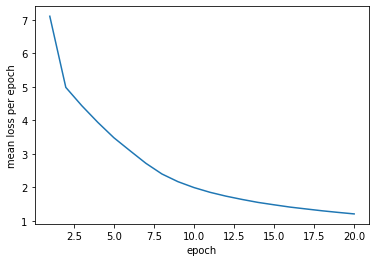

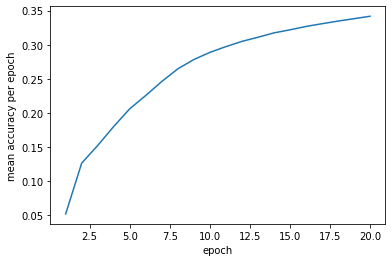

In [33]:
fig = plt.figure()
plt.plot(np.arange(1,num_epochs+1), train_loss_per_epoch)
plt.ylabel('mean loss per epoch')
plt.xlabel('epoch')
fig.savefig('./'+ checkpoint_folder +'/mean loss per epoch.png')

fig = plt.figure()
plt.plot(np.arange(1,num_epochs+1), train_accuracy_per_epoch)
plt.ylabel('mean accuracy per epoch')
plt.xlabel('epoch')
fig.savefig('./'+ checkpoint_folder +'/mean accuracy per epoch.png')

## Evaluate 

### The funtions 'evaluate' and 'translate' and the testing examples were taken from https://www.tensorflow.org/tutorials/text/transformer which uses TensorFlow 2.0 and were modified accordingly for TensorFlow 1.15

In [34]:
def evaluate(inp_sentence):

    dropout_rate = 0
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = np.expand_dims(inp_sentence, 0)
    
    decoder_input = [tokenizer_en.vocab_size]
    output = np.expand_dims(decoder_input, 0)

    model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          maximum_position_input = input_vocab_size, maximum_position_target = target_vocab_size, rate = dropout_rate)

    with tf.Session() as sess:
        
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(checkpoint_folder))

        for i in range(MAX_LENGTH):
            
            feed = {model.encoder_input: encoder_input,
                   model.decoder_input: output,
                   model.target: output}
            
            batch_predictions = sess.run(model.predictions, feed_dict=feed)
                    
            # select the last word from the Ty dimension
            predictions = batch_predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
            
            predicted_id = np.argmax(predictions, axis=-1)
            predicted_id = predicted_id.astype(int)
            
            # return the result if the predicted_id is equal to the end token
            if predicted_id == tokenizer_en.vocab_size+1:
                return np.squeeze(output, axis=0)
        
            # concatentate the predicted_id to the output which is given to the decoder # as its input.
            output = np.concatenate((output, predicted_id), axis=-1)
    
        return np.squeeze(output, axis=0)

In [35]:
def translate(sentence):
    
    result = evaluate(sentence)
  
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

### Example 1

In [36]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


Input: este é um problema que temos que resolver.
Predicted translation: this is a problem we have to solve .
Real translation: this is a problem we have to solve .


### Example 2

In [37]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: my neighbors heard about this idea .
Real translation: and my neighboring homes heard about this idea .


### Example 3

In [38]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


INFO:tensorflow:Restoring parameters from checkpoints_transformer_language_translation/transformer.ckpt


Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i 'm going to share with you a few stories of some magic things that happened .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


## Number of trainable parameters

In [39]:
model = transformer_model(num_layers = num_layers, d_model = d_model, num_heads = num_heads, d_ff = d_ff, 
                          input_vocab_size = input_vocab_size, target_vocab_size = target_vocab_size, 
                          maximum_position_input = input_vocab_size, maximum_position_target = target_vocab_size, rate = dropout_rate)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    total_parameters = 0
    for variable in tf.trainable_variables():
        print(variable)
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value

        total_parameters += variable_parameters
    print('total number of trainable parameters: ',total_parameters)

<tf.Variable 'Encoder/embedding/embeddings:0' shape=(8216, 128) dtype=float32>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_1/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_1/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_2/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_2/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_3/weights:0' shape=(128, 128) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/mha/fully_connected_3/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'Encoder/Encoder_layer_1/layer_normalization/gamma:0' shape=(128,) dtype=flo